In [66]:
import jax.numpy as jnp
import jax
import jax.scipy as jsp
import matplotlib.pyplot as plt
import os

Lets load some images.

In [76]:
def load_data(path):
    # load all images from this path
    images = []
    for file in os.listdir(path):
        if file.endswith(".jpg"):
            images.append(plt.imread(os.path.join(path, file)))

    return images

def preprocess(images, size=32):
    # resize
    images = [jax.image.resize(image, (size, size, 3), method="linear") for image in images]
    # normalize
    images = [image / 255. for image in images]
    # reshape
    images = jnp.array(images)
    return images

images_raw = load_data("data")
images = preprocess(images_raw[0:100])

(100, 32, 32, 3)


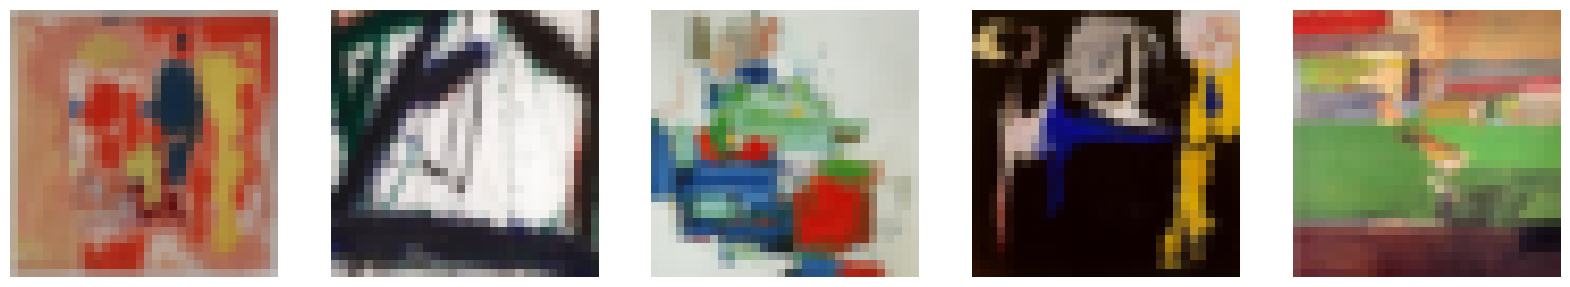

In [77]:
print(images.shape)

# generate 5 plots in a row
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(images[i])
    axs[i].axis("off")

In [78]:
from flax import linen as nn
from flax import struct
import optax
from typing import Any, Callable

In [179]:
class Encoder(nn.Module):
    n_channels: int

    def setup(self):
        self.conv1 = nn.Conv(features=self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv2 = nn.Conv(features=2*self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv3 = nn.Conv(features=4*self.n_channels, kernel_size=(3, 3), strides=(2, 2))

    def __call__(self, x):
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.conv3(x)
        x = jax.nn.relu(x)
        return x

In [180]:
class Decoder(nn.Module):
    n_channels: int

    def setup(self):
        self.conv1 = nn.ConvTranspose(features=4*self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv2 = nn.ConvTranspose(features=2*self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv3 = nn.ConvTranspose(features=self.n_channels, kernel_size=(3, 3), strides=(2, 2))
    
    def __call__(self, x):
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.conv3(x)
        x = jax.nn.relu(x)

        return x

In [181]:
class Autoencoder(nn.Module):
    n_channels: int

    def setup(self):
        self.encoder = Encoder(n_channels=self.n_channels)
        self.decoder = Decoder(n_channels=self.n_channels)
    
    def __call__(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [190]:
from functools import partial

def reconstruction_loss(network_params : optax.Params,  network : nn.Module, images : jnp.ndarray):
  # print(images.shape)
  prediction = network.apply(network_params, images)
  # print(prediction.shape)
  # print(prediction.shape, images.shape)
  loss = jnp.mean(jnp.square(prediction - images))
  return loss

@partial(jax.jit, static_argnums=(0,1))
def train_step(
  network : nn.Module,
  optimizer : optax.GradientTransformation,
  optimizer_state : optax.OptState,
  network_params : optax.Params):

  grad_fn = jax.value_and_grad(reconstruction_loss, argnums=0)
  loss, grads = grad_fn(network_params, network, images)

  updates, new_opt_state = optimizer.update(grads, optimizer_state)

  new_network_params = optax.apply_updates(network_params, updates)

  return loss, new_network_params, new_opt_state


In [192]:
init_rng = jax.random.key(0)

learning_rate = 0.0001

autoencoder = Autoencoder(n_channels=3)

network_params = autoencoder.init(init_rng, images[0])
# autoencoder_params = autoencoder_state
optimizer = optax.adam(learning_rate)
optimizer_state = optimizer.init(network_params)

num_epochs = 20

for epoch in range(num_epochs):

    # loss_sum = 0
    # for i in range(images.shape[0]):
    #     loss, network_params, optimizer_state = train_step(
    #         autoencoder,
    #         optimizer,
    #         optimizer_state,
    #         network_params
    #     )
    #     loss_sum += loss

    # same using vmapped version
    train_step_lambda = lambda state, images: train_step(state, images)

    loss, state = jax.vmap(train_step_lambda, in_axes=(None, 0))(state, images)
    loss_sum = jnp.sum(loss)

    print(f'epoch {epoch}, loss {loss_sum / images.shape[0]}')


ValueError: Non-hashable static arguments are not supported. An error occurred while trying to hash an object of type <class '__main__.TrainState'>, TrainState(params={'decoder': {'conv1': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[-1.54379487e-01, -9.96148512e-02,  2.13164240e-01, ...,
           1.78282410e-01,  1.09576881e-01,  5.67541867e-02],
         [-3.49372886e-02, -1.17925167e-01,  1.81863941e-02, ...,
          -3.89548056e-02, -1.07464470e-01, -1.04794808e-01],
         [-8.03392832e-05,  6.00328371e-02, -8.72278735e-02, ...,
           2.44210698e-02,  8.09005648e-02,  6.66164011e-02],
         ...,
         [ 9.18363631e-02,  1.47886828e-01, -1.37541905e-01, ...,
          -6.94617778e-02,  1.01710856e-01, -1.82731733e-01],
         [-8.59351456e-02, -1.26124188e-01,  1.85507517e-02, ...,
           1.91134848e-02,  2.84833983e-02,  1.29189327e-01],
         [-9.41000655e-02,  6.41419515e-02,  1.77256286e-01, ...,
          -2.77739074e-02, -1.52592147e-02,  6.10582642e-02]],

        [[ 1.60345510e-02, -9.04293284e-02, -5.63635910e-03, ...,
          -1.22808494e-01, -3.65507603e-02,  4.22556326e-02],
         [ 9.59965051e-04,  8.10241476e-02,  7.20838532e-02, ...,
           2.07959767e-03,  5.79229854e-02,  1.76080987e-01],
         [ 2.01816503e-02,  1.19904220e-01,  1.64827868e-01, ...,
           2.02067345e-01, -1.63526013e-01,  5.03424481e-02],
         ...,
         [-7.46043175e-02,  3.91766150e-03, -1.31963091e-02, ...,
          -4.37192321e-02, -1.07689850e-01, -1.09633066e-01],
         [-1.12065894e-03,  7.33353794e-02, -2.96693537e-02, ...,
           9.09295976e-02, -4.38089333e-02, -1.50235295e-01],
         [-1.29152134e-01,  7.88428932e-02, -5.37891611e-02, ...,
           3.00046522e-02,  9.22129005e-02, -7.68583938e-02]],

        [[ 4.08535637e-02,  1.02731353e-02,  1.34106755e-01, ...,
          -6.53816983e-02, -1.86025709e-01,  1.56053845e-02],
         [ 1.01997137e-01, -1.35875672e-01, -1.06356796e-02, ...,
          -1.02415331e-01, -2.43541915e-02,  7.87106752e-02],
         [-8.03072229e-02, -6.69213291e-03,  9.05272290e-02, ...,
           1.30225211e-01, -1.59592450e-01,  7.13103339e-02],
         ...,
         [ 5.36800064e-02, -1.05230555e-01,  8.58903769e-03, ...,
          -5.81175275e-02, -2.64140852e-02, -1.19264022e-01],
         [-9.09183249e-02,  3.44585907e-03,  1.73732057e-01, ...,
           9.77177545e-02,  3.48531120e-02,  2.02624589e-01],
         [ 1.14747435e-01,  8.96675419e-03, -2.49324460e-02, ...,
          -1.06665157e-01, -5.28125614e-02, -1.85534973e-02]]],


       [[[ 2.11016480e-02,  5.29946573e-02, -8.08152854e-02, ...,
          -1.17914394e-01, -1.94237396e-01, -7.96910897e-02],
         [ 1.62258983e-01, -1.32522672e-01, -5.76272607e-02, ...,
           3.09439693e-02, -6.78975368e-03,  1.18515268e-01],
         [ 8.16639587e-02,  7.54040182e-02,  1.04098901e-01, ...,
           2.70872656e-03,  1.34881377e-01, -6.02303967e-02],
         ...,
         [ 5.54430448e-02, -5.60832918e-02,  5.76953068e-02, ...,
           4.26908135e-02,  1.04907468e-01,  1.11449592e-01],
         [-2.22492474e-03,  8.72456096e-03, -7.65469745e-02, ...,
          -9.14283767e-02, -9.18069407e-02,  1.71714365e-01],
         [-3.63418870e-02,  1.17682882e-01, -3.40526402e-02, ...,
          -5.44177517e-02,  4.02899161e-02, -1.46550804e-01]],

        [[ 2.60162223e-02,  5.89863881e-02,  1.57473817e-01, ...,
          -3.72928344e-02,  1.95145104e-02, -1.74212027e-02],
         [-6.41935393e-02, -1.38938963e-01, -1.02831781e-01, ...,
           5.01020625e-02,  5.73288910e-02,  1.76133290e-01],
         [-8.02548230e-02, -3.38273272e-02,  6.65545985e-02, ...,
           5.90809509e-02, -7.99969658e-02,  3.71400975e-02],
         ...,
         [ 1.87044740e-01,  6.36191061e-03,  3.21939439e-02, ...,
           2.42566504e-02, -1.03464045e-01, -1.32093206e-01],
         [ 7.11032897e-02, -1.16495460e-01,  1.66776523e-01, ...,
          -5.41587535e-04, -1.13560341e-01,  9.72293019e-02],
         [ 1.05520830e-01,  1.55489564e-01,  2.04703927e-01, ...,
          -1.51817977e-01,  2.46872175e-02, -4.41585034e-02]],

        [[-2.73093041e-02,  5.38658909e-02,  4.07413021e-02, ...,
           1.61013424e-01, -1.80245966e-01,  2.96625197e-02],
         [-6.35651574e-02,  3.59203294e-02,  5.80428690e-02, ...,
           4.22234274e-02,  2.11118045e-03,  6.54649436e-02],
         [-4.42085750e-02,  1.63629372e-02,  1.23487197e-01, ...,
          -7.67706409e-02,  5.95136695e-02,  7.61361197e-02],
         ...,
         [-1.75378695e-01, -2.78600436e-02, -7.40921348e-02, ...,
           6.90801516e-02, -1.19043872e-01,  1.47015397e-02],
         [-5.71970753e-02,  1.34616345e-01,  5.50457463e-02, ...,
           9.47975442e-02,  1.64526820e-01, -2.66292095e-02],
         [-3.73794511e-02, -3.02737374e-02,  4.21088599e-02, ...,
           1.78869125e-02, -1.03918046e-01, -1.96111742e-02]]],


       [[[ 1.33965433e-01, -5.57098910e-02, -4.92464527e-02, ...,
          -1.18959524e-01, -1.11375652e-01,  1.50345713e-01],
         [-1.39631256e-01, -6.91115856e-02,  1.25454262e-01, ...,
          -1.78142842e-02,  8.29802081e-02,  7.33753890e-02],
         [ 3.41188237e-02,  1.59285352e-01, -1.09458134e-01, ...,
          -4.12959158e-02, -1.08708434e-01,  1.69379413e-02],
         ...,
         [-1.29166156e-01,  3.66587704e-03,  1.78554460e-01, ...,
          -1.26422793e-01,  4.20202650e-02, -6.01777919e-02],
         [-3.69420461e-02,  1.71423241e-01,  6.41304022e-03, ...,
           1.12642080e-01,  4.50414978e-02,  7.10275099e-02],
         [ 1.25946373e-01,  6.43399581e-02,  1.69254363e-01, ...,
          -1.53507426e-01, -4.49349685e-03,  3.98080647e-02]],

        [[-4.79135290e-02, -1.99119939e-04,  2.03348979e-01, ...,
           2.13076264e-01, -2.85017281e-03, -2.14259028e-02],
         [-1.52316242e-01, -9.20745544e-03, -2.34671459e-02, ...,
          -4.03528363e-02,  2.17124727e-02,  6.68073595e-02],
         [-3.03905923e-02,  1.35886416e-01, -1.02727190e-01, ...,
          -1.00250229e-01,  2.72961780e-02, -5.60774617e-02],
         ...,
         [ 1.03050638e-02, -1.07891031e-01, -8.55799168e-02, ...,
           2.64773443e-02, -1.53584592e-02,  7.68067222e-03],
         [-8.00859034e-02, -1.11946024e-01, -6.30578995e-02, ...,
          -8.56834650e-02, -3.63277756e-02,  1.40554324e-01],
         [ 1.46087766e-01,  1.13295042e-03,  6.89261174e-03, ...,
           1.29853442e-01, -1.25977352e-01, -4.32864502e-02]],

        [[-1.29194915e-01, -8.91889036e-02, -6.08100146e-02, ...,
          -1.12948619e-01,  9.16104317e-02,  1.14377879e-01],
         [-1.15134016e-01,  9.08296406e-02,  8.33148062e-02, ...,
           9.58074816e-03, -3.20224799e-02, -6.62455708e-02],
         [ 4.04791050e-02, -5.64104468e-02, -2.52065379e-02, ...,
          -6.48659691e-02, -2.77396515e-02, -1.17173031e-01],
         ...,
         [ 9.66296494e-02,  1.23916261e-01, -3.56713706e-03, ...,
           8.12285841e-02,  2.96239462e-02,  9.11831856e-02],
         [ 1.70118555e-01,  3.08863912e-03,  1.04634613e-01, ...,
          -2.67653037e-02, -1.51257098e-01,  1.78447925e-02],
         [-9.54058096e-02, -6.19167695e-03,  1.26653478e-01, ...,
          -1.18478294e-02,  4.73099351e-02,  1.99985147e-01]]]],      dtype=float32)}, 'conv2': {'bias': Array([0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[-1.66865364e-02,  5.61343655e-02,  1.35031044e-01,
          -1.72583565e-01,  5.93575500e-02,  3.29682864e-02],
         [ 1.89399689e-01, -1.62881300e-01,  8.86293873e-02,
          -9.97326970e-02,  3.02330740e-02, -1.85750872e-01],
         [ 3.93441357e-02,  6.86689764e-02, -1.62415002e-02,
          -1.38329295e-03, -8.56582448e-02,  1.14352386e-02],
         [-4.70627174e-02,  3.93922590e-02, -6.46231994e-02,
          -2.54383106e-02, -1.71834305e-02, -5.58969900e-02],
         [ 1.42870592e-02,  9.76789370e-02, -1.24562413e-01,
          -6.67832717e-02, -5.81518039e-02,  1.70640629e-02],
         [ 3.26325116e-03, -8.95658694e-03,  1.09519310e-01,
          -1.55626731e-02, -2.46089455e-02,  5.23409341e-03],
         [-1.94583982e-01, -1.17096297e-01,  3.67212407e-02,
           4.81741517e-05,  3.28116305e-02, -6.84199035e-02],
         [-1.10409297e-01,  5.55687100e-02,  1.36487976e-01,
          -9.76729766e-02, -1.30069414e-02,  3.81856486e-02],
         [ 4.51150872e-02,  8.46040696e-02, -8.64696056e-02,
          -6.17995532e-03,  1.12238266e-01,  4.44196090e-02],
         [ 6.60371184e-02, -7.64276460e-02,  3.24048987e-03,
           7.90902320e-03,  1.71758011e-01,  1.04769133e-01],
         [ 9.46235284e-02,  2.74247136e-02, -5.64501099e-02,
           1.42181709e-01, -1.44735336e-01,  3.01129390e-02],
         [ 5.98493814e-02, -5.93336597e-02, -2.74376627e-02,
          -8.22250545e-02,  5.96937649e-02, -1.05025284e-01]],

        [[-4.59215231e-02, -6.70058429e-02, -3.59548032e-02,
           3.52943987e-02,  1.17200933e-01, -5.35267219e-02],
         [-5.97753935e-02, -1.33757383e-01,  1.82151735e-01,
           5.97635992e-02,  1.44146293e-01,  4.60638329e-02],
         [-1.20154798e-01, -1.76238999e-01,  1.25454992e-01,
          -8.73107929e-03,  1.45890340e-01,  1.76829934e-01],
         [-5.62027022e-02,  9.44577679e-02, -9.19883251e-02,
          -7.51954764e-02, -3.82645167e-02, -6.20154757e-03],
         [-4.49252985e-02,  4.84732538e-02, -1.94674060e-01,
           5.97408898e-02, -1.96398884e-01,  7.26151913e-02],
         [ 8.04399252e-02, -4.47181016e-02, -4.06879410e-02,
          -9.34768021e-02, -1.82395518e-01, -3.21346126e-03],
         [-1.20065242e-01, -4.57082987e-02,  1.10515498e-01,
           6.14892095e-02, -4.81696539e-02, -3.43614109e-02],
         [-5.97356334e-02, -1.26291409e-01, -1.77253503e-02,
          -2.72323228e-02, -3.40211391e-02,  1.48393229e-01],
         [ 7.92869255e-02,  1.53464913e-01, -1.14304185e-01,
          -7.35604689e-02, -7.37416819e-02, -2.46086512e-02],
         [ 6.48591965e-02,  9.16265510e-03,  4.40568943e-03,
          -9.71373990e-02, -1.00857401e-02,  1.02553926e-01],
         [-6.96998369e-03, -9.34250355e-02,  8.03318247e-02,
           1.72499791e-01, -5.16440868e-02,  2.63546892e-02],
         [ 8.63405466e-02, -5.06278425e-02, -1.94349498e-01,
           5.09567298e-02, -2.61936486e-02,  5.99592812e-02]],

        [[-1.51435323e-02, -7.89697841e-03,  1.19232625e-01,
          -1.38724716e-02,  7.99986720e-02,  4.32251543e-02],
         [ 9.44321677e-02, -5.22590578e-02,  9.93496850e-02,
           1.66349322e-01,  1.40561825e-02,  1.40378311e-01],
         [-1.25232369e-01, -4.57510017e-02, -6.93051964e-02,
           1.38004169e-01, -2.30933540e-02, -7.37185627e-02],
         [-2.89291162e-02, -7.46056214e-02,  7.20130876e-02,
           1.28160372e-01, -2.15476066e-01,  5.55373020e-02],
         [-1.24332830e-01,  6.76578507e-02,  5.48300594e-02,
           1.83326870e-01, -8.07335302e-02,  2.87199137e-03],
         [-1.55588584e-02,  1.00801162e-01,  4.12415154e-02,
          -1.46031184e-02, -4.30576839e-02,  3.59467044e-02],
         [-1.80123612e-01, -9.67578031e-03,  8.38100612e-02,
          -1.37365177e-01, -2.98345666e-02, -9.89894792e-02],
         [ 1.69601068e-01, -1.51541889e-01,  1.61096498e-01,
           1.08456939e-01,  1.09761044e-01, -2.06971820e-02],
         [-1.20149970e-01,  4.70683873e-02,  1.10928658e-02,
          -1.19454838e-01, -1.31575465e-01,  4.23922576e-03],
         [ 8.65210872e-03, -1.31146060e-02,  1.17564097e-01,
           5.96174151e-02,  3.05513963e-02, -9.68318209e-02],
         [ 1.11541450e-01,  9.68195871e-02, -6.78028911e-02,
           1.49215221e-01, -3.53556387e-02,  5.78255840e-02],
         [-1.20376736e-01, -1.50705263e-01, -2.77287997e-02,
           6.13695718e-02, -6.11892268e-02, -1.09086931e-01]]],


       [[[-5.54980375e-02, -6.86533302e-02, -4.05691518e-03,
          -5.90045415e-02, -1.22433811e-01,  1.67760238e-01],
         [-8.38219747e-02,  9.39250663e-02,  4.49728370e-02,
          -7.39634335e-02,  4.39783186e-02,  1.04290336e-01],
         [ 8.41018334e-02, -9.08226296e-02,  1.36720523e-01,
           7.93479234e-02, -7.89440274e-02, -9.65278503e-03],
         [-1.37098730e-01, -2.80485637e-02, -1.24456279e-01,
          -1.68741480e-01,  3.00435014e-02, -1.23421900e-01],
         [ 5.06474674e-02, -1.19503491e-01,  8.60748738e-02,
          -3.73318270e-02,  2.06450820e-01, -9.59748030e-02],
         [ 1.93373486e-02, -3.70636247e-02, -6.30828738e-02,
          -2.97128893e-02,  1.27221152e-01,  1.78680912e-01],
         [ 6.58279518e-03,  1.22039877e-01,  2.00312391e-01,
          -1.77658111e-01,  2.23530121e-02,  1.23929821e-01],
         [ 4.35375515e-03,  4.48250398e-03, -7.52759874e-02,
           4.24731383e-03, -7.16309175e-02, -7.95522258e-02],
         [ 1.38484836e-02,  6.23394474e-02,  2.01063499e-01,
           1.59582615e-01,  1.75780475e-01,  6.24119714e-02],
         [-2.50616409e-02, -1.06954217e-01,  6.70033097e-02,
          -4.59088199e-02,  9.74130034e-02, -6.65825233e-02],
         [-1.01739787e-01,  3.74088809e-02, -1.94536112e-02,
          -1.98039472e-01,  1.05374604e-01, -1.44769192e-01],
         [-5.83945960e-02, -1.36236176e-01,  3.43675427e-02,
           6.44403175e-02, -9.10475478e-02,  1.09583065e-01]],

        [[ 4.58756983e-02,  1.34364948e-01, -1.20771669e-01,
           1.58622190e-01, -5.63713908e-02,  7.25445673e-02],
         [ 5.81461899e-02, -5.56005165e-02, -8.52222275e-03,
           1.16362967e-01, -1.68115899e-01, -1.91383306e-02],
         [ 3.21076773e-02,  2.16343611e-01, -1.92089409e-01,
           7.88389668e-02, -1.52186513e-01, -1.06763460e-01],
         [ 7.72337988e-02,  5.27426824e-02, -1.52003309e-02,
          -5.93097322e-02,  3.95951383e-02, -1.84585169e-01],
         [-2.81173829e-02, -1.71068355e-01,  1.60590798e-01,
          -9.58318934e-02, -1.22415908e-01,  1.18583575e-01],
         [ 3.18378471e-02, -1.02801844e-02,  1.38138816e-01,
          -8.77283886e-02, -7.35422820e-02, -1.62738904e-01],
         [-1.83947057e-01, -1.79651231e-01,  8.49846825e-02,
          -9.89420786e-02, -8.65568817e-02,  1.46729112e-01],
         [-2.06851438e-02,  1.16398418e-02,  1.68054730e-01,
          -1.41149417e-01,  2.14688063e-01,  4.12032604e-02],
         [-9.24289376e-02, -1.20917425e-01,  1.57832652e-02,
          -4.23207916e-02, -4.03012447e-02,  3.79734375e-02],
         [ 5.84725961e-02, -5.41503578e-02,  1.34445921e-01,
           7.24745840e-02,  1.05467543e-01, -1.56967659e-02],
         [ 1.95175838e-02, -1.91674709e-01,  3.75635773e-02,
           1.95569828e-01,  2.02124700e-01, -2.13157386e-02],
         [ 6.25004694e-02, -9.63264704e-02, -1.54064342e-01,
          -1.59450825e-02,  2.01915428e-02, -1.37285888e-02]],

        [[-1.59451529e-01, -1.31973162e-01,  1.04626819e-01,
          -2.60194913e-02,  9.49000120e-02, -1.17780045e-01],
         [-1.17247976e-01,  5.98445050e-02,  5.04452810e-02,
           9.10331309e-02, -5.92102297e-02, -1.66190580e-01],
         [-7.26143792e-02,  6.93857670e-02, -2.14768872e-02,
           1.39494956e-01,  2.12171838e-01, -5.62269874e-02],
         [-1.47221521e-01, -4.26685587e-02, -5.86295798e-02,
          -8.79511014e-02, -9.31416228e-02, -8.57044607e-02],
         [ 1.33460134e-01,  1.10248365e-01, -1.52411982e-01,
           2.53676325e-02, -1.16120376e-01, -9.61108878e-02],
         [-2.60287616e-02, -7.15105310e-02,  3.18241380e-02,
           4.61069867e-02,  6.57010078e-02,  1.56032994e-01],
         [ 1.26557618e-01, -3.15541029e-02, -1.27755120e-01,
          -1.21908551e-02, -1.90094262e-01, -4.79668751e-02],
         [ 1.71802416e-01,  1.22914493e-01, -1.33654982e-01,
          -3.12734060e-02, -5.30542694e-02, -6.70076832e-02],
         [ 1.62079055e-02,  3.35180126e-02, -2.80203819e-02,
           1.19982541e-01,  1.52932167e-01, -1.43120706e-01],
         [ 3.06574013e-02,  4.78643551e-02,  4.15164083e-02,
           3.69255990e-02, -4.95600030e-02, -7.87375942e-02],
         [ 4.41247560e-02,  2.18095869e-01,  9.41726714e-02,
           2.01610357e-01,  6.73047528e-02,  5.30336089e-02],
         [ 7.71790966e-02, -7.77247623e-02, -1.37858495e-01,
          -1.51752040e-01, -2.08764493e-01,  1.32873639e-01]]],


       [[[ 2.95811892e-02, -1.12752512e-01,  3.39319482e-02,
          -9.32495669e-02,  4.43025343e-02, -1.86354183e-02],
         [ 6.88271299e-02,  1.76632434e-01,  6.94906414e-02,
          -3.94188017e-02,  1.93319377e-02,  6.36896566e-02],
         [-8.38902444e-02,  4.64415811e-02, -6.15020022e-02,
          -3.10775656e-02,  1.75079122e-01,  5.10449568e-03],
         [-2.90753469e-02,  1.73465125e-02, -3.04636583e-02,
           3.90382633e-02,  1.17483750e-01, -6.91519678e-02],
         [ 1.56194255e-01,  3.09726857e-02,  5.95180839e-02,
          -1.00026563e-01, -1.85677856e-01,  2.45304517e-02],
         [ 1.55385524e-01, -1.63136721e-01, -1.78408459e-01,
          -2.83182673e-02,  6.11989386e-03, -3.74389254e-02],
         [ 1.29781291e-02,  2.61710789e-02,  6.96398020e-02,
           1.50686175e-01,  3.47821414e-02, -5.30366041e-03],
         [-1.72234938e-01, -5.19163720e-02, -1.26644718e-02,
          -7.38608837e-02,  3.78476903e-02, -1.35929352e-02],
         [ 1.41621158e-01,  1.71708480e-01,  1.93031672e-02,
          -1.67937949e-01, -8.90129283e-02, -1.07331842e-01],
         [-1.00306254e-02,  4.57326099e-02,  6.84580766e-03,
          -1.43963709e-01, -1.61152527e-01, -1.60967514e-01],
         [-1.40602574e-01,  5.22079691e-02,  1.47345454e-01,
          -7.01339990e-02,  9.32103172e-02,  1.36615664e-01],
         [-7.77319968e-02, -8.46499726e-02,  2.22223699e-02,
           3.08118314e-02, -1.12079784e-01,  1.74383938e-01]],

        [[ 7.33434036e-02,  2.02335626e-01, -6.01078942e-02,
          -3.77069153e-02,  2.11969502e-02,  1.26021743e-01],
         [-8.20539147e-03, -5.69710545e-02, -6.95694908e-02,
           8.42380747e-02,  8.67956206e-02,  6.66005462e-02],
         [ 1.37669593e-01, -1.54984206e-01,  1.52590543e-01,
           1.20008051e-01, -1.82868820e-02,  1.64200872e-01],
         [-1.37299806e-01,  2.79034185e-03, -5.45874089e-02,
          -1.99149940e-02, -6.12531565e-02,  1.45835325e-01],
         [-1.64809510e-01, -3.50365229e-02, -1.12185426e-01,
          -1.32905692e-01,  5.31887896e-02,  7.47243240e-02],
         [-5.02329357e-02,  1.89251229e-02,  1.96281411e-02,
           1.35819033e-01, -5.75652113e-03, -1.98572397e-01],
         [ 3.76384240e-03,  9.60910246e-02, -3.66277061e-02,
           1.02305077e-01, -3.00944019e-02, -1.40288338e-01],
         [-9.19351876e-02, -8.41166675e-02, -1.94283769e-01,
          -6.97650686e-02, -6.92280680e-02,  1.08320124e-01],
         [ 2.26643495e-02, -2.68804170e-02, -1.67441621e-01,
           1.20808005e-01, -2.04609096e-01, -1.60786182e-01],
         [-1.40495867e-01, -2.04353347e-01,  3.07913050e-02,
          -1.06476240e-01, -1.65554792e-01, -7.53115714e-02],
         [-9.99642015e-02, -6.30818009e-02, -3.81880775e-02,
          -6.90556690e-02,  3.89128253e-02,  5.49637228e-02],
         [ 2.29431074e-02,  7.17515796e-02,  1.12053998e-01,
           1.19046912e-01,  1.10503085e-01,  1.33368699e-02]],

        [[ 6.38191681e-03, -6.61198050e-03,  8.54974836e-02,
          -3.50074247e-02, -1.36681842e-02, -3.76276858e-02],
         [ 1.70351624e-01,  4.47322205e-02, -1.03341797e-02,
           4.44150679e-02,  2.11281031e-01, -4.24904078e-02],
         [ 1.96605790e-02, -1.02323435e-01,  2.54098754e-02,
          -7.60560036e-02,  7.26581439e-02, -3.03843282e-02],
         [ 9.90633573e-03, -9.82165709e-03, -1.85061172e-01,
          -2.89131906e-02, -1.44654289e-01,  3.50366198e-02],
         [ 5.70181571e-02, -2.54201666e-02, -8.12621713e-02,
          -1.27992675e-01, -1.51156858e-02, -1.29575795e-02],
         [-1.04519419e-01, -2.17973180e-02,  4.93870936e-02,
           1.79673538e-01,  1.13809900e-03, -1.10870674e-01],
         [ 1.67762592e-01, -1.09536245e-01,  2.17938572e-01,
           2.00423673e-01,  1.40655600e-02,  1.66289449e-01],
         [ 1.10618822e-01, -8.78868923e-02,  5.11651002e-02,
           4.49653305e-02, -5.42020686e-02, -1.03668213e-01],
         [-1.36435390e-01,  3.08974106e-02,  3.35967652e-02,
          -7.16677727e-03, -8.98494124e-02,  1.25781253e-01],
         [ 1.70342010e-02,  1.47747934e-01,  6.62333965e-02,
           1.65087786e-02,  9.55017582e-02,  4.49983589e-02],
         [ 4.17477190e-02,  8.43767375e-02, -1.72179654e-01,
           1.54290855e-01, -4.16769227e-03, -1.64639264e-01],
         [ 1.17273025e-01, -2.16235220e-01, -5.44340611e-02,
          -2.60368846e-02,  1.15534440e-01, -3.41587998e-02]]]],      dtype=float32)}, 'conv3': {'bias': Array([0., 0., 0.], dtype=float32), 'kernel': Array([[[[ 0.00310354,  0.219632  ,  0.14906138],
         [ 0.11589418, -0.02979647, -0.01447354],
         [ 0.23848464,  0.20952272,  0.11809892],
         [-0.19398098,  0.0278733 , -0.22525036],
         [-0.16860351, -0.0169615 ,  0.11799267],
         [-0.22001691, -0.22371402,  0.0037808 ]],

        [[ 0.0137404 ,  0.14424115,  0.23610182],
         [-0.04137992,  0.24515735,  0.12468857],
         [ 0.02596191,  0.06588251,  0.08410303],
         [ 0.06184544, -0.17920947, -0.13391668],
         [ 0.04216662, -0.15273517, -0.04360522],
         [-0.25976405,  0.21128683,  0.01915518]],

        [[-0.10669817, -0.19282581,  0.22308308],
         [ 0.10134014,  0.15784445,  0.1998189 ],
         [ 0.18007539, -0.09452429, -0.01035841],
         [-0.25588727, -0.10691874, -0.00409886],
         [ 0.12205149, -0.04488245, -0.07616833],
         [-0.05616511,  0.01235606,  0.00286593]]],


       [[[ 0.13394699,  0.10292094, -0.19322075],
         [ 0.13674696, -0.10651486,  0.01834682],
         [-0.01766758,  0.03786037, -0.02588786],
         [-0.10880371,  0.05467991, -0.0548939 ],
         [ 0.13412482,  0.00135107, -0.07777069],
         [-0.05599217, -0.05445742, -0.1473218 ]],

        [[-0.1374073 , -0.01852432,  0.06977935],
         [ 0.00163706,  0.02183183,  0.21552354],
         [ 0.06964652,  0.27439585,  0.16397598],
         [ 0.11140141, -0.04748011,  0.00672897],
         [ 0.11759285,  0.02235636, -0.14961909],
         [-0.00903511, -0.05619932,  0.28193864]],

        [[ 0.28894803,  0.01790246, -0.16423984],
         [-0.1588412 ,  0.06388132,  0.16759755],
         [ 0.01191501,  0.17950462,  0.19957072],
         [ 0.01725831, -0.13715088,  0.05809299],
         [ 0.19311878, -0.22806692,  0.03243391],
         [ 0.16853178, -0.09734043,  0.1533375 ]]],


       [[[ 0.0783898 ,  0.03037858,  0.17130414],
         [ 0.00821351, -0.07720499,  0.03414098],
         [ 0.12501973,  0.20024899, -0.00264333],
         [-0.06430546, -0.17092358,  0.25516966],
         [-0.15339638,  0.21803173,  0.0885227 ],
         [-0.03091973, -0.05491378, -0.01117253]],

        [[-0.04240141, -0.23520555,  0.22887166],
         [-0.00755983,  0.01605855,  0.10956714],
         [ 0.14787386,  0.08804456,  0.08473583],
         [-0.01039816, -0.13667203,  0.06559207],
         [-0.28148222,  0.05059086, -0.16111505],
         [-0.06261422, -0.10804752, -0.2440109 ]],

        [[-0.05179334,  0.28090927, -0.0056187 ],
         [ 0.07970138, -0.13864085,  0.01593716],
         [-0.08758713,  0.16308351,  0.13803984],
         [ 0.13795708,  0.11334621, -0.11310934],
         [-0.13619024,  0.24837835,  0.09921467],
         [ 0.01482669, -0.08752418, -0.01833959]]]], dtype=float32)}}, 'encoder': {'conv1': {'bias': Array([0., 0., 0.], dtype=float32), 'kernel': Array([[[[ 0.19362485,  0.13189465, -0.17396122],
         [-0.10337497, -0.02866821, -0.2124424 ],
         [-0.19622661, -0.24576072, -0.01075726]],

        [[ 0.07241788, -0.21261625,  0.00237213],
         [-0.13272314, -0.08308787,  0.22917454],
         [-0.18362898,  0.2070336 ,  0.20075928]],

        [[ 0.10102717,  0.17452982, -0.23766817],
         [-0.19903989,  0.07868921, -0.3653007 ],
         [ 0.09013622,  0.2817805 ,  0.21737942]]],


       [[[ 0.06275811, -0.00865824,  0.24538979],
         [-0.13849509, -0.19498183, -0.36201948],
         [-0.01466163,  0.01262173,  0.05446605]],

        [[-0.13961941, -0.138712  ,  0.03077332],
         [ 0.29903004, -0.09575543,  0.00690003],
         [-0.2848129 , -0.28861237,  0.2682029 ]],

        [[ 0.16526067,  0.01534008, -0.13712624],
         [ 0.17120905, -0.17515063,  0.27654833],
         [ 0.15649398,  0.14062032, -0.14305468]]],


       [[[ 0.09204759,  0.27504224,  0.01585816],
         [ 0.0025599 ,  0.31163222,  0.28593668],
         [-0.4219192 , -0.28582102, -0.11176688]],

        [[ 0.26368338,  0.01625164,  0.17695005],
         [-0.27585524, -0.15458314,  0.0168302 ],
         [ 0.0537549 ,  0.22858164,  0.22743452]],

        [[ 0.09373292,  0.40773433, -0.06175982],
         [ 0.03600574,  0.12979989, -0.12631765],
         [-0.17553684,  0.06596711, -0.1072802 ]]]], dtype=float32)}, 'conv2': {'bias': Array([0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[ 0.31898466,  0.01248349,  0.30945042,  0.02498573,
          -0.1287038 ,  0.1818942 ],
         [-0.14204869,  0.383843  , -0.11853273,  0.22821973,
          -0.22130974, -0.21620111],
         [ 0.31293094, -0.15898983, -0.03648776,  0.04818106,
           0.16682294, -0.24693309]],

        [[ 0.04563012, -0.07748345,  0.15406552,  0.04546658,
           0.06523546, -0.20567425],
         [ 0.08501638, -0.06793179, -0.03197745,  0.14482158,
          -0.12364748,  0.26352733],
         [ 0.09647737,  0.17277297, -0.06370289, -0.02747146,
           0.33339596, -0.41195044]],

        [[ 0.3667839 , -0.27307868, -0.15324593,  0.08134136,
           0.05146182, -0.36044875],
         [-0.24897572, -0.26665384,  0.10479153,  0.0616788 ,
          -0.21468332, -0.26082698],
         [ 0.005227  , -0.23338512, -0.34308156, -0.11030665,
          -0.08128755, -0.2394197 ]]],


       [[[-0.30375993,  0.0658268 , -0.00048504, -0.02296077,
          -0.26356804, -0.11355643],
         [ 0.03001965,  0.04539406, -0.3175907 ,  0.0584525 ,
          -0.18371312,  0.23189576],
         [ 0.19475909,  0.23385113, -0.00067674, -0.15215857,
           0.06123713, -0.07311664]],

        [[-0.17336836,  0.07811775,  0.08306552,  0.33823183,
          -0.25680488, -0.04265061],
         [ 0.15695041, -0.02496085,  0.01796483,  0.16008508,
          -0.17601854, -0.00334635],
         [ 0.05944092,  0.08793126, -0.07568353, -0.19768113,
          -0.04895066,  0.23171718]],

        [[ 0.16153306,  0.02525377,  0.21638694,  0.00265094,
          -0.08452876, -0.12613516],
         [-0.10104042,  0.36894822, -0.06047277, -0.19403397,
           0.14166775, -0.19376154],
         [ 0.20270318,  0.06585208, -0.18876745,  0.3804832 ,
           0.05601273,  0.04974641]]],


       [[[-0.09334425, -0.035165  ,  0.05621542,  0.01875011,
          -0.07510994, -0.10545394],
         [ 0.07954697, -0.06749772, -0.2539708 , -0.07339119,
           0.19386482, -0.01905389],
         [-0.22559565, -0.06306261,  0.1075624 ,  0.04036716,
           0.08275772,  0.21074821]],

        [[ 0.08510292, -0.02840287, -0.20510909,  0.15818657,
           0.13533664,  0.05756916],
         [-0.13285841, -0.19914278, -0.01462836, -0.21562886,
           0.06388866,  0.09245295],
         [-0.30023026, -0.05698093,  0.2844927 ,  0.28595716,
          -0.1783332 ,  0.0906949 ]],

        [[-0.08357566, -0.04062222,  0.3469212 , -0.24562813,
          -0.2369346 , -0.17061092],
         [-0.32940972, -0.01127766, -0.24562825, -0.1374835 ,
          -0.06911824,  0.03716335],
         [ 0.15974976,  0.07155114, -0.24580644,  0.15601975,
          -0.06929871,  0.26938415]]]], dtype=float32)}, 'conv3': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[-8.74339975e-03,  1.02758743e-01, -1.68917090e-01,
           1.18399203e-01, -6.38193786e-02, -2.45974615e-01,
           1.62679270e-01, -1.64896488e-01, -1.29315466e-01,
          -2.37500668e-01,  2.60625154e-01, -1.37790749e-02],
         [ 1.91358820e-01, -8.28535855e-02,  9.71214026e-02,
          -3.54127884e-02,  1.03165150e-01,  1.63483888e-01,
           1.30651638e-01,  2.83732116e-01, -2.31863279e-02,
          -2.29935702e-02, -4.32354696e-02, -2.21907571e-01],
         [ 1.73482358e-01,  1.63024422e-02, -8.00086260e-02,
           1.80296049e-01,  6.69627339e-02, -3.78335454e-03,
          -1.65990889e-01, -1.37665808e-01,  2.91495442e-01,
           1.99794516e-01, -3.13473605e-02,  5.89912757e-02],
         [ 5.49023598e-02,  2.97963440e-01,  2.30089143e-01,
          -2.41747051e-01, -1.68356389e-01, -3.92601220e-03,
          -1.92265019e-01, -1.20414212e-01,  6.45312443e-02,
          -1.83037698e-01, -1.51858225e-01,  2.92437166e-01],
         [ 2.71403249e-02, -2.12194100e-01,  9.75015089e-02,
          -1.22864366e-01, -7.77759999e-02,  2.72428513e-01,
          -4.54714336e-02,  1.28502458e-01,  1.36226043e-01,
           3.88456993e-02, -9.86555219e-02,  2.90090084e-01],
         [ 1.58450782e-01,  1.39079094e-01, -1.06286123e-01,
          -1.61326975e-02, -4.94569801e-02,  5.43354414e-02,
           1.71021596e-01,  1.87742319e-02, -7.92769268e-02,
           2.49332353e-01, -1.62868246e-01, -1.51383400e-01]],

        [[-2.44509608e-01,  2.21043378e-01,  1.03717046e-02,
           4.17972691e-02, -2.22919434e-01,  1.51462644e-01,
          -5.14193475e-02, -1.57934695e-01,  6.06145384e-03,
           5.05157150e-02,  1.55629337e-01, -1.77790552e-01],
         [ 1.32484227e-01,  8.21076855e-02,  4.68839407e-02,
           3.37978117e-02,  9.67444014e-03,  4.30628844e-02,
          -1.82582155e-01,  7.98295215e-02,  1.62595898e-01,
           1.99953616e-01,  1.75931722e-01, -6.37455955e-02],
         [ 3.80895995e-02,  2.74306864e-01, -9.43498686e-02,
          -1.54897302e-01, -2.67569851e-02,  5.65534532e-02,
          -2.22670212e-01,  3.63514833e-02, -2.53402501e-01,
           5.90328174e-03,  1.31212324e-01, -6.54320279e-03],
         [-2.95219272e-01,  1.44471169e-01, -1.21905722e-01,
           4.44337465e-02,  7.57627264e-02,  1.45082781e-02,
          -2.86708385e-01,  1.60643443e-01, -9.42921825e-03,
          -5.72172329e-02,  2.28590101e-01, -6.46606609e-02],
         [ 1.98925033e-01, -2.63697207e-01, -4.95812669e-02,
          -9.02001709e-02, -1.11494578e-01,  2.46478498e-01,
           2.68328518e-01, -7.25279450e-02,  4.25887760e-03,
           8.80539641e-02,  1.62492856e-01, -5.77841662e-02],
         [-3.42850341e-04, -1.72313675e-02, -2.73721874e-01,
          -1.41730502e-01,  7.33267590e-02, -9.40528587e-02,
           1.68639466e-01, -5.82390837e-02,  8.07301179e-02,
          -7.39138201e-02,  4.50826883e-02,  1.44754320e-01]],

        [[-1.11768499e-01,  9.17019472e-02, -4.82640117e-02,
          -3.73377129e-02, -5.71476854e-02, -4.10960838e-02,
          -1.19713247e-01, -3.71222850e-04, -7.12576136e-02,
           1.89620405e-01,  3.31513323e-02, -2.23270617e-02],
         [-7.12008998e-02,  9.13358778e-02,  5.24147674e-02,
          -1.16507776e-01, -5.91376871e-02,  4.75053675e-02,
           1.11590378e-01,  4.48661223e-02, -4.71195243e-02,
          -4.75405604e-02, -2.23742411e-01,  1.04627877e-01],
         [ 1.32295996e-01,  6.95202053e-02, -2.60004461e-01,
          -1.13838740e-01, -8.96724686e-02,  7.02795982e-02,
           2.73356855e-01,  1.16997957e-01,  1.62041754e-01,
          -1.35322347e-01, -2.33785719e-01,  4.66374913e-03],
         [ 9.98591110e-02,  1.75004631e-01, -6.25393819e-03,
          -1.63522691e-01,  2.00784966e-01,  9.28402394e-02,
           4.08971347e-02, -1.03974015e-01,  1.23217650e-01,
          -1.02087252e-01, -1.80900134e-02, -1.27780080e-01],
         [ 2.09388316e-01, -1.79385588e-01,  6.12485781e-03,
           8.78765807e-02,  1.41187787e-01,  5.12769520e-02,
          -6.19457699e-02,  1.49484664e-01,  2.27264151e-01,
           1.75649166e-01,  2.09286585e-01, -2.25942269e-01],
         [-9.15666893e-02, -2.33647525e-02,  7.47249648e-03,
           1.66645408e-01, -1.85471371e-01,  1.86052427e-01,
          -1.49111345e-01, -2.55211830e-01,  3.86399440e-02,
           2.44353294e-01, -1.81169882e-01, -2.29970098e-01]]],


       [[[-1.28527328e-01,  1.31317243e-01,  1.67219266e-01,
          -1.66798546e-03,  1.45461455e-01,  2.67142981e-01,
           1.54665723e-01, -1.78042144e-01, -4.30061594e-02,
           9.05341730e-02, -2.33834535e-01, -1.56303003e-01],
         [-2.76257955e-02,  1.84034824e-01, -3.89873385e-02,
          -1.28364742e-01, -2.60817222e-02, -3.86758186e-02,
           1.95503468e-03, -7.34863281e-02,  8.15549679e-03,
           1.36248946e-01,  2.10739389e-01, -4.30078991e-02],
         [ 1.35243833e-01,  1.48383021e-01, -9.27928984e-02,
           7.54944533e-02, -1.98075309e-01, -8.57827663e-02,
          -1.43236443e-01, -6.08365536e-02,  1.34843718e-02,
          -3.44268754e-02, -1.20024972e-01,  1.92604721e-01],
         [ 2.04030067e-01, -2.22515002e-01, -7.64278397e-02,
           2.22037554e-01,  6.29483089e-02, -2.10073460e-02,
           1.80412203e-01,  1.98051348e-01,  7.76821747e-02,
           5.35760657e-04, -1.58327490e-01, -7.77486041e-02],
         [-1.47893764e-02, -4.77679335e-02,  1.85494676e-01,
           1.31878993e-02, -1.45742059e-01, -5.43453358e-02,
           8.99540912e-03,  1.21917337e-01, -1.37873769e-01,
           1.71941414e-01,  1.63669631e-01, -4.02256437e-02],
         [ 4.75383438e-02,  6.87690750e-02,  8.62561911e-02,
          -2.38472521e-01,  9.45051983e-02, -1.02882661e-01,
          -1.63853526e-01, -2.68912226e-01,  1.72800690e-01,
           2.37466976e-01, -6.29345998e-02,  6.80550709e-02]],

        [[ 8.94538686e-02,  1.43524677e-01, -2.38964617e-01,
           1.22560412e-01,  5.20976027e-03,  1.14320084e-01,
           1.86355695e-01,  1.87497526e-01,  7.11792260e-02,
           2.46756095e-02, -1.21193193e-01,  2.60914326e-01],
         [ 2.40830258e-02,  1.23396866e-01, -1.07771635e-01,
          -2.15147913e-01, -2.28099123e-01, -3.91188450e-03,
          -1.85953721e-01, -9.51548293e-02, -8.31767544e-02,
           7.73528069e-02,  1.69068605e-01,  2.29828760e-01],
         [ 9.14649740e-02, -1.20217822e-01, -1.48454890e-01,
          -8.17942247e-02, -1.79558888e-01, -3.55574442e-03,
          -8.60987306e-02,  2.46553540e-01,  2.61426926e-01,
          -1.33305714e-01, -6.05339482e-02, -7.04471543e-02],
         [-2.57651019e-03, -2.34948829e-01, -4.83476743e-02,
           1.39204532e-01,  3.75823006e-02,  1.57549575e-01,
          -9.75126028e-02, -2.07908139e-01,  2.50179004e-02,
           9.05577391e-02,  2.91898251e-01, -1.59837127e-01],
         [-2.75001358e-02, -3.47793587e-02,  1.53540134e-01,
           5.12234457e-02, -4.16239947e-02,  1.69477600e-03,
          -1.09713776e-02, -9.02203545e-02,  5.07758185e-02,
          -2.21232399e-01, -2.37565837e-04,  3.68554108e-02],
         [ 1.21654294e-01,  5.64886369e-02,  2.03089416e-01,
          -5.20008206e-02, -7.61173666e-02, -9.35164373e-03,
          -9.45580602e-02, -3.73459868e-02,  8.53032917e-02,
           1.37198884e-02,  3.51717696e-02, -9.03997645e-02]],

        [[ 2.31322050e-01,  1.57256365e-01, -3.19828652e-02,
           2.12726183e-02, -1.02591053e-01,  1.03833087e-01,
           2.75736637e-02,  7.12907836e-02,  1.19841509e-01,
           9.93527379e-03,  3.40002850e-02,  8.73896107e-02],
         [ 2.69850820e-01, -3.08346562e-02,  4.29523215e-02,
           5.56668006e-02,  2.47237399e-01,  1.47413954e-01,
          -9.58051831e-02,  1.03673637e-01,  2.19667897e-01,
           1.26543447e-01,  8.72819945e-02,  1.10963471e-01],
         [-1.64849773e-01,  1.29689470e-01,  1.01123042e-02,
           1.95988536e-01,  6.40895450e-03, -4.68369685e-02,
           1.30997375e-01, -2.09644318e-01,  2.41159678e-01,
          -5.67915961e-02,  3.24506164e-02,  1.58291385e-01],
         [ 1.88341215e-02,  8.15169886e-02,  7.27011636e-02,
           2.66437382e-01, -9.62291807e-02, -1.39751166e-01,
          -9.57821980e-02, -8.56083184e-02, -2.96018213e-01,
           1.69501156e-01,  3.05468947e-01, -1.86659798e-01],
         [ 1.71575360e-02,  1.76348418e-01, -4.98483367e-02,
          -1.22550443e-01,  2.31445909e-01, -3.40046808e-02,
          -1.31527428e-02, -1.98876128e-01,  1.04931585e-01,
          -1.33131579e-01, -3.87992933e-02,  1.74412638e-01],
         [ 8.04751515e-02,  5.04413657e-02,  8.37004483e-02,
          -1.23094015e-01, -2.35869009e-02,  7.16139004e-02,
           3.43007930e-02, -2.19370604e-01, -2.94224471e-01,
           8.71739909e-02, -7.32723325e-02,  2.55896091e-01]]],


       [[[ 2.30775490e-01,  3.88012603e-02,  2.42303446e-01,
           2.61603832e-01,  1.63389206e-01,  1.48285538e-01,
          -1.86585158e-01, -1.21627495e-01, -1.22487292e-01,
           1.68534424e-02,  1.21628931e-02, -2.06752624e-02],
         [-1.82529271e-01,  2.38788500e-02,  2.68454421e-02,
          -7.79265724e-03, -2.04223953e-03, -2.83701986e-01,
           3.01049560e-01, -1.07896235e-02, -1.23098947e-01,
          -5.59546761e-02, -4.61566076e-02,  9.39230472e-02],
         [ 4.66194563e-03,  1.06270716e-01,  2.24334672e-01,
           6.34363368e-02,  2.07599793e-02, -8.37458596e-02,
          -8.35204050e-02,  1.42522410e-01, -6.04522265e-02,
           2.10600883e-01, -3.01764429e-01,  2.08505228e-01],
         [ 2.66929325e-02,  2.29802907e-01, -1.19742237e-01,
           2.82094628e-01,  1.78332239e-01,  2.80977726e-01,
          -6.23491332e-02, -4.03313637e-02,  2.23556146e-01,
          -1.05850831e-01,  5.33824414e-02, -2.97643356e-02],
         [ 2.56808132e-01, -2.42178682e-02, -4.80237789e-02,
           8.62845555e-02, -7.02826381e-02,  9.01383087e-02,
           8.10135379e-02,  1.74321532e-02,  1.24667220e-01,
           2.12654412e-01, -2.27736667e-01, -1.40283421e-01],
         [ 2.80502383e-02,  5.76429218e-02,  6.71995133e-02,
           9.71276015e-02,  7.06097260e-02, -2.31274255e-02,
          -9.61376578e-02,  7.38429576e-02,  1.58143073e-01,
           1.22290909e-01,  5.49155250e-02, -1.58462703e-01]],

        [[ 3.66761126e-02,  2.03251094e-02, -7.99802467e-02,
          -3.49378511e-02, -9.46049765e-02,  6.08646870e-02,
          -7.77806938e-02, -4.75801677e-02,  8.51978175e-03,
           8.43598843e-02,  5.81037812e-03, -1.11768909e-01],
         [-4.44105789e-02,  4.88704443e-03,  1.96099043e-01,
          -1.33318380e-01,  6.17565401e-02,  1.66744292e-01,
           1.41131684e-01, -9.31354687e-02, -8.91758129e-03,
           1.06815897e-01,  2.76683122e-01, -7.44375214e-02],
         [-2.21872672e-01, -2.71235883e-01, -2.67734706e-01,
          -1.49795547e-01,  1.25856742e-01, -3.51455174e-02,
           2.18279392e-01,  2.46540055e-01, -8.54568556e-02,
          -2.22668156e-01,  1.03537753e-01, -2.64957786e-01],
         [ 1.26760766e-01,  1.07964337e-01,  7.28563145e-02,
          -2.88098194e-02,  7.16550723e-02,  4.56474302e-03,
          -1.03664733e-01,  1.18513286e-01,  9.90817323e-02,
           1.69959471e-01, -9.88980457e-02,  1.40082464e-01],
         [-1.43443897e-01, -2.48344857e-02,  5.68198189e-02,
          -5.46741709e-02,  2.80750662e-01,  8.94270986e-02,
           5.62322326e-02, -2.40039885e-01,  1.09985486e-01,
           1.18775815e-01, -5.46014169e-03,  6.81672292e-03],
         [-7.95759168e-03, -7.95144774e-03,  1.23918921e-01,
          -1.50489122e-01, -3.64312790e-02, -9.81921181e-02,
           4.66299755e-03,  1.50840431e-01,  4.43942919e-02,
          -2.53112495e-01, -6.33819550e-02, -4.42132577e-02]],

        [[-5.80002517e-02, -6.33376315e-02,  1.99642573e-02,
           2.57130176e-01,  2.49597058e-03,  1.21988386e-01,
           3.45139094e-02,  4.63064620e-03,  4.97748554e-02,
          -3.58177237e-02, -1.22109698e-02, -1.59792200e-01],
         [-4.08262797e-02,  1.23516604e-01,  5.25802262e-02,
          -5.78053147e-02, -4.69364263e-02, -1.35482192e-01,
           1.53996050e-01, -7.86630362e-02,  3.27583472e-03,
           2.27901250e-01, -1.01593621e-02, -1.23257965e-01],
         [ 4.72965688e-02, -2.71965638e-02, -1.84020862e-01,
           1.76527128e-01, -2.32618809e-01, -3.00320596e-01,
           1.54849321e-01, -4.46334407e-02, -4.37184013e-02,
          -1.01059780e-03, -8.15933868e-02, -3.30223180e-02],
         [ 4.28496562e-02, -9.32468846e-02,  9.71223339e-02,
           4.52414975e-02, -4.42053005e-02,  5.73768653e-02,
           4.41609062e-02, -1.96754456e-01, -5.96058220e-02,
          -4.15080264e-02,  2.31112882e-01, -4.75148894e-02],
         [-1.00636519e-01, -8.45998898e-02,  1.33747011e-02,
           9.93200392e-02, -9.05660465e-02, -5.08741327e-02,
           2.50680614e-02,  2.17981674e-02, -4.76193428e-02,
          -6.55131713e-02, -2.31150463e-01,  9.20687616e-02],
         [ 1.60803363e-01,  2.57113427e-01, -6.29504696e-02,
           1.15406156e-01,  4.27250890e-03, -1.52835995e-01,
          -5.82967885e-02, -1.94980502e-01, -2.44945109e-01,
           1.32570267e-01, -1.50480554e-01,  1.05105899e-01]]]],      dtype=float32)}}}, optimizer=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7f971099e9e0>, update=<function chain.<locals>.update_fn at 0x7f97108949d0>), opt_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu={'decoder': {'conv1': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'conv2': {'bias': Array([0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]]], dtype=float32)}, 'conv3': {'bias': Array([0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)}}, 'encoder': {'conv1': {'bias': Array([0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)}, 'conv2': {'bias': Array([0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]]], dtype=float32)}, 'conv3': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]],      dtype=float32)}}}, nu={'decoder': {'conv1': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)}, 'conv2': {'bias': Array([0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]]], dtype=float32)}, 'conv3': {'bias': Array([0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)}}, 'encoder': {'conv1': {'bias': Array([0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)}, 'conv2': {'bias': Array([0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]]], dtype=float32)}, 'conv3': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'kernel': Array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]],      dtype=float32)}}}), EmptyState())). The error was:
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_732/1779917117.py", line 29, in <module>
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/jax/_src/api.py", line 1214, in vmap_f
  File "/home/andrinr/projects/msc-thesis/generator.env/lib/python3.10/site-packages/jax/_src/linear_util.py", line 192, in call_wrapped
  File "/tmp/ipykernel_732/1779917117.py", line 27, in <lambda>
  File "<string>", line 3, in __hash__
TypeError: unhashable type: 'dict'
